<a href="https://colab.research.google.com/github/Kennethdotse/ML_for_under_sea_fibre_cable_monitoring/blob/main/Sensitivity_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/22:05:23/'

Mounted at /content/drive


In [2]:
from pydub import AudioSegment
import os

def concatenate_audio_from_path(audio_paths, output_filename="combined_audio.flac"):
    """
    Concatenates audio files from a list of paths and exports the result to a FLAC file.

    Parameters:
    audio_paths (list): A list of strings, where each string is the path to an audio file.
    output_filename (str): Name of the output file to save the concatenated audio.

    Returns:
    None
    """

    # Check if any audio files were provided
    if not audio_paths:
        print("No audio files provided.")
        return

    # Load the first audio file to start concatenation
    try:
        combined_audio = AudioSegment.from_file(audio_paths[0])
    except Exception as e:
        print(f"Error loading the first audio file {audio_paths[0]}: {e}")
        return


    # Iterate through the rest of the files and append them to the combined audio
    for audio_file in audio_paths[1:]:
        try:
            next_audio = AudioSegment.from_file(audio_file)
            combined_audio += next_audio
        except Exception as e:
            print(f"Error loading and concatenating {audio_file}: {e}")
            # Optionally, you could skip this file and continue or stop
            continue

    # Export the final combined audio to a FLAC file
    try:
        combined_audio.export(output_filename, format="flac")
        # Notify user of the saved file
        print(f"Concatenated audio saved to {output_filename}")
    except Exception as e:
        print(f"Error exporting the combined audio file: {e}")


output_filename = "combined_audio.flac"
# Assuming data_path is defined elsewhere and contains the directory
# where your audio files are located in Google Drive.
# Let's list the files in the data_path and filter for audio files if necessary.
# For demonstration, let's assume all files in data_path are audio files to be concatenated.
# You might need to adjust this based on your actual file structure.
audio_files_in_drive = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith(('.wav', '.mp3', '.flac', '.ogg'))] # Add more extensions if needed
audio_files_in_drive.sort() # Sort to ensure consistent order

# Use only the last 20 audio files
audio_files_to_use = audio_files_in_drive[-20:]

concatenate_audio_from_path(audio_files_to_use, output_filename)

Concatenated audio saved to combined_audio.flac


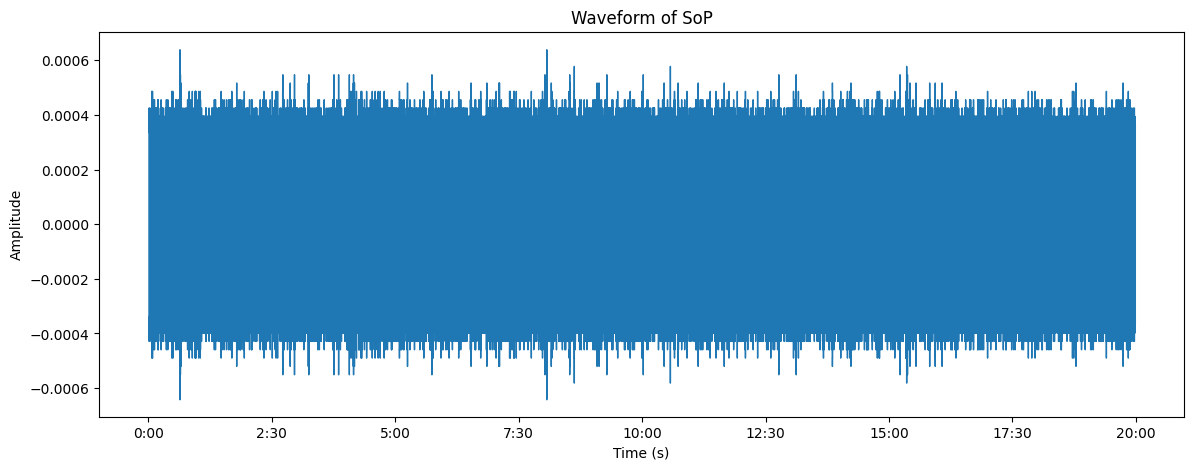

In [3]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

def show_waveform(output_filename, sr=44100):
  # Load the combined audio file
  y, sr = librosa.load(output_filename, sr=44100, mono=False)
  # Plot the waveform
  plt.figure(figsize=(14, 5))
  sop = y[0] - y[1]

  librosa.display.waveshow(y[0]-y[1], sr=sr)
  plt.title('Waveform of SoP')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.show()

  return y, sop, sr


y, sop, sr = show_waveform(output_filename)



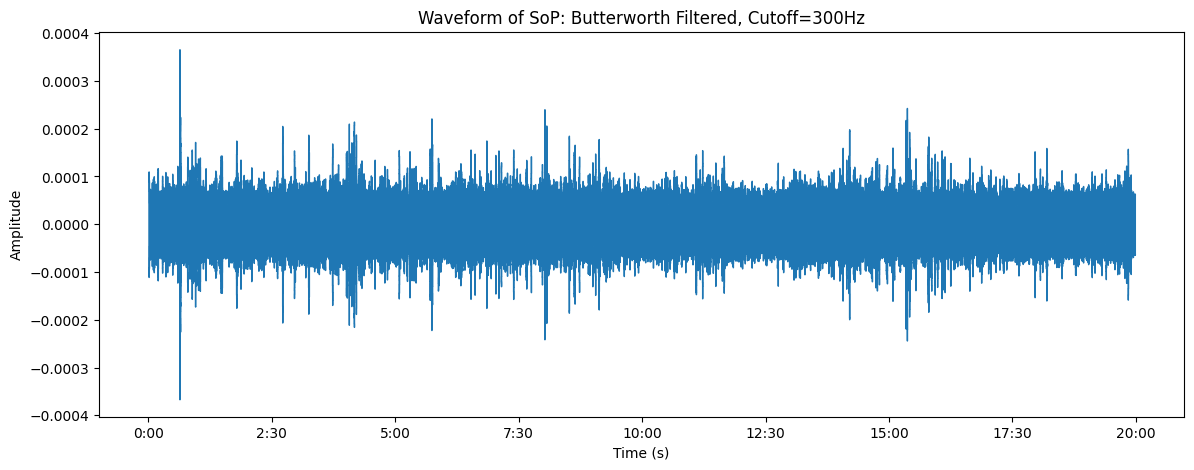

In [4]:
# prompt: pass the sop through a butterworth filter function with cutoff frequency of 300Hz
from scipy.signal import butter, filtfilt

def butter_filter(data, cutoff, fs, order=4):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Apply the Butterworth filter to the sop signal
cutoff_frequency = 300  # Hz
sop_filtered = butter_filter(sop, cutoff_frequency, sr)

def plot_waveform_general(waveform, sr, extra_info):
  plt.figure(figsize=(14, 5))
  librosa.display.waveshow(waveform, sr=sr)
  plt.title(f'Waveform of SoP: {extra_info}')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.show()

plot_waveform_general(sop_filtered, sr, f'Butterworth Filtered, Cutoff={cutoff_frequency}Hz')

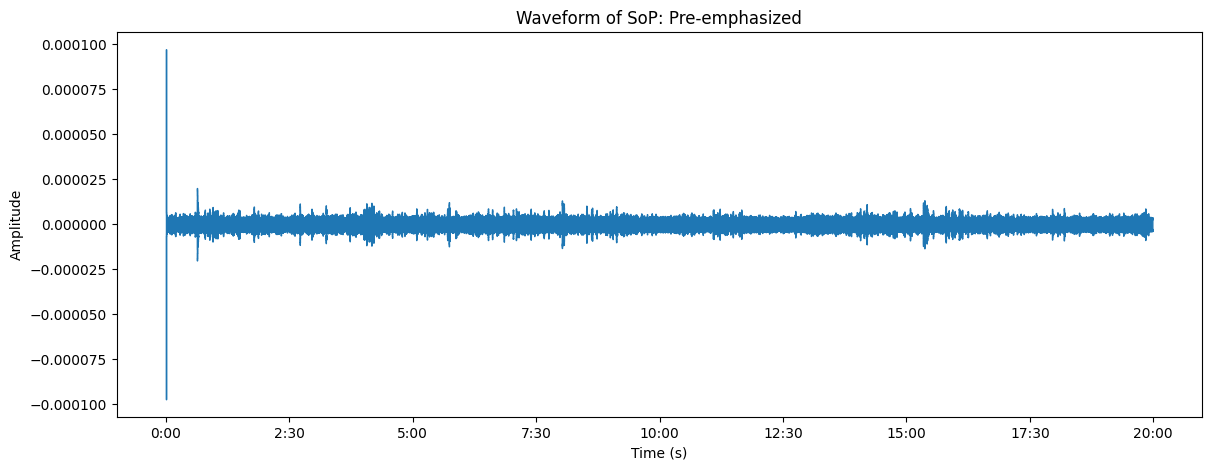

In [5]:
from scipy.signal import lfilter
def pre_emphasize(signal, coeff=0.9459):
    return lfilter([1, -coeff], [1], signal)

pre_emphasized_sop = pre_emphasize(sop_filtered)
plot_waveform_general(pre_emphasized_sop, sr, 'Pre-emphasized')



In [6]:
def extract_mfcc_global_norm(y, sr=44100, n_mfcc=13, n_fft_ms=20, hop_length_ms=10, maxi=None, mini=None):
    """
    Extracts MFCC features and applies global min-max normalization to the entire matrix.

    Parameters:
        y (np.ndarray): Audio time series.
        sr (int): Sampling rate.
        n_mfcc (int): Number of MFCCs to return (default 13).

    Returns:
        np.ndarray: Normalized MFCC array (shape: (n_mfcc - 1, n_frames))
    """
    sop = y[0] - y[1]

    cutoff_frequency = 300  # Hz
    sop_filtered = butter_filter(sop, cutoff_frequency, sr)

    pre_emphasized_sop = pre_emphasize(sop_filtered)
    frame_len = int(sr * n_fft_ms / 1000)
    hop_len = int(sr * hop_length_ms / 1000)

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(
        y=pre_emphasized_sop,
        sr=sr,
        n_mfcc=n_mfcc,
        n_fft=frame_len,
        hop_length=hop_len,
        n_mels=30,
        window='hamming'
    )

    # Drop the first coefficient (energy)
    mfcc_squeezed = mfccs[1:, :]  # shape: (n_mfcc - 1, n_frames)

    # Global normalization
    mini = np.min(mfcc_squeezed) if mini is None else mini
    maxi = np.max(mfcc_squeezed) if maxi is None else maxi
    mfccs_norm = 2 * (mfcc_squeezed - mini) / (maxi - mini) - 1

    return mfccs_norm.T, sop_filtered, sr, frame_len, hop_len, maxi, mini


In [7]:
mfccs_norm_global, sop_filtered, sr, frame_len, hop_len, maxi, mini = extract_mfcc_global_norm(y)

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader

# Convert the NumPy array to a PyTorch Tensor
# Transpose the mfccs_norm array to have shape (number_of_frames, number_of_mfccs)
mfccs_tensor = torch.FloatTensor(mfccs_norm_global)

class MFCCDataset(Dataset):
    def __init__(self, mfccs_tensor):
        self.mfccs = mfccs_tensor

    def __len__(self):
        return len(self.mfccs)

    def __getitem__(self, idx):
        return self.mfccs[idx]

# Create the dataset and dataloader
dataset = MFCCDataset(mfccs_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

In [9]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim=13, latent_dim=64):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x) # Latent space, no activation
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim=32, output_dim=13):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x) # Output layer, linear activation
        return x

class Autoencoder(nn.Module):
    def __init__(self, input_dim=13, latent_dim=32):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim=input_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, output_dim=input_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [10]:
import torch.optim as optim

def train_autoencoder(model, dataloader, input_dim=12, latent_dim=16,
                      learning_rate=0.001, num_epochs=100, patience=10,
                      save_path='best_autoencoder.pth'):
    """
    Trains an autoencoder model with early stopping.

    Parameters:
        model (nn.Module): Autoencoder model instance.
        dataloader (DataLoader): PyTorch DataLoader containing input data.
        input_dim (int): Dimensionality of input features (for reference/logging).
        latent_dim (int): Size of the latent representation (for reference/logging).
        learning_rate (float): Learning rate for the optimizer.
        num_epochs (int): Maximum number of training epochs.
        patience (int): Number of epochs with no improvement before stopping early.
        save_path (str): File path to save the best model.

    Returns:
        nn.Module: Trained model with the best weights loaded.
    """
    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data in dataloader:
            inputs = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

        # Early stopping check
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print('Early stopping!')
                break

    # Load the best model before returning
    model.load_state_dict(torch.load(save_path))
    print('Finished Training')
    return model


In [ ]:
input_dim = 12
latent_dim = 32
model = Autoencoder(input_dim=input_dim, latent_dim=latent_dim)
model = train_autoencoder(model, dataloader, input_dim=input_dim, latent_dim=latent_dim)

Epoch [1/100], Loss: 0.0015
Epoch [2/100], Loss: 0.0000
Epoch [3/100], Loss: 0.0000
Epoch [4/100], Loss: 0.0000
Epoch [5/100], Loss: 0.0000
Epoch [6/100], Loss: 0.0000
Epoch [7/100], Loss: 0.0000
Epoch [8/100], Loss: 0.0000
Epoch [9/100], Loss: 0.0000
Epoch [10/100], Loss: 0.0000
Epoch [11/100], Loss: 0.0000
Epoch [12/100], Loss: 0.0000


In [ ]:
# Load the best model for evaluation and anomaly detection
model.load_state_dict(torch.load('best_autoencoder.pth'))
model.eval()

In [ ]:
# Function to compute reconstruction error for anomaly detection
def compute_reconstruction_error(model, mfccs):
    mfccs_tensor = torch.FloatTensor(mfccs) # Ensure correct shape (frames, mfccs)
    with torch.no_grad():
        reconstructed_mfccs = model(mfccs_tensor)
        mse = torch.mean((mfccs_tensor - reconstructed_mfccs)**2, dim=1)
    return mse.numpy()


# For demonstration, let's use the training data to show the reconstruction error
reconstruction_errors = compute_reconstruction_error(model, mfccs_norm_global)
plt.figure(figsize=(14, 5))
plt.plot(reconstruction_errors)
plt.title('Reconstruction Error Over Time of Training Data')
plt.xlabel('Frame Index')
plt.ylabel('MSE')
plt.show()


In [ ]:
uploaded = files.upload()
audio_files = list(uploaded.keys())
print(audio_files)

In [ ]:
test_output_filename = "test_audio"
concatenate_uploaded_audio(uploaded, test_output_filename)

In [ ]:
y_test, sop_test, sr = show_waveform(test_output_filename)

In [ ]:
sop_filtered_test = butter_filter(sop_test, cutoff_frequency, sr)

In [ ]:
plot_waveform_general(sop_filtered_test, sr, 'Test Clip - Butterworth Filtered, Cutoff=300Hz')

In [ ]:
mfccs_norm_test, test_sop_filtered, sr, frame_len, hop_len, maxi_test, mini_test = extract_mfcc_global_norm(y_test, maxi=maxi, mini=mini)

In [ ]:
reconstruction_errors_test = compute_reconstruction_error(model, mfccs_norm_test)
plt.figure(figsize=(14, 5))
plt.plot(reconstruction_errors_test)
plt.title('Reconstruction Error Over Time of Test Data')
plt.xlabel('Frame Index')
plt.ylabel('MSE')
plt.show()

In [ ]:
def plot_waveform_with_anomalies(y, sr, reconstruction_errors, threshold, frame_length, hop_length):
  """
    Plots the audio waveform highlighting sections with reconstruction error above a threshold.

    Args:
        y (np.ndarray): The audio waveform.
        sr (int): The sampling rate.
        reconstruction_errors (np.ndarray): Array of reconstruction errors per frame.
        threshold (float): The threshold for classifying a frame as anomalous.
        frame_length (int): The number of audio samples in a frame.
        hop_length (int): The number of audio samples in a hop.
    """
  plt.figure(figsize=(14, 5))
  times = librosa.times_like(reconstruction_errors, sr=sr, hop_length=hop_length)

  # Determine which frames are anomalous based on the threshold
  anomalous_frames_bool = reconstruction_errors > threshold

  # Create an array to store the anomaly status for each sample
  sample_anomaly_status = np.zeros_like(y, dtype=bool)

  # Propagate frame anomaly status to samples within the frame's effective duration
  # A sample is considered anomalous if it falls within *any* frame that is marked as anomalous
  for i, is_anomalous_frame in enumerate(anomalous_frames_bool):
    if is_anomalous_frame:
      start_sample = i * hop_length
      # The end sample should cover the entire window for that frame
      end_sample = min(start_sample + frame_length, len(y))
      sample_anomaly_status[start_sample:end_sample] = True

  # Split the waveform based on anomaly status
  normal_y = y.copy()
  anomalous_y = y.copy()

  normal_y[sample_anomaly_status] = np.nan
  anomalous_y[~sample_anomaly_status] = np.nan

  # Plot the normal parts
  plt.plot(librosa.times_like(normal_y, sr=sr), normal_y, color='blue', label='Normal')

  # Plot the anomalous parts
  plt.plot(librosa.times_like(anomalous_y, sr=sr), anomalous_y, color='red', label='Anomalous')


  plt.title('Waveform with Anomalous Sections')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.legend()
  plt.show()

plot_waveform_with_anomalies(test_sop_filtered, 44100, reconstruction_errors_test, 2.8540124049669524, frame_len, hop_len)

In [ ]:
print(reconstruction_errors_test)
from scipy.stats import genpareto

u = np.percentile(reconstruction_errors_test, 95)
print(u)
exceedances = reconstruction_errors_test[reconstruction_errors_test > u] - u
c, loc, scale = genpareto.fit(exceedances)
gpd_thresh = genpareto.ppf(0.21, c, loc, scale)  # 99% threshold in tail
final_thresh = u + gpd_thresh
print(final_thresh)
#anomalies = errors > final_thresh

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

def sliding_kmeans_thresholds(
    errors: np.ndarray,
    window_size: int = 4500,
    std_multiplier: float = 2,
    min_cluster_diff: float = 1e-4,
    random_state: int = 42
) -> np.ndarray:
    """
    Generate adaptive thresholds using KMeans clustering over a sliding window.

    Args:
        errors (np.ndarray): Array of reconstruction errors.
        window_size (int): Size of the rolling window.
        std_multiplier (float): Multiplier for standard deviation to determine significant cluster separation.
        min_cluster_diff (float): Minimum absolute difference between clusters to consider.
        random_state (int): Seed for reproducibility.

    Returns:
        np.ndarray: Array of thresholds, same length as errors, with NaN for the first (window_size) entries.
    """
    thresholds = np.full_like(errors, fill_value=np.nan, dtype=float)

    for i in range(window_size, len(errors)):
        window = errors[i - window_size:i].reshape(-1, 1)
        std_dev = np.std(window)

        # Run KMeans with 2 clusters
        kmeans = KMeans(n_clusters=2, n_init='auto', random_state=random_state)
        labels = kmeans.fit_predict(window)
        centers = kmeans.cluster_centers_.flatten()

        high_cluster = np.argmax(centers)
        low_cluster = np.argmin(centers)
        center_diff = centers[high_cluster] - centers[low_cluster]

        # Check if the difference is significant
        if center_diff > max(std_multiplier * std_dev, min_cluster_diff):
            # Use the mean of the higher cluster as threshold
            threshold = centers[high_cluster]
        else:
            # Use fallback threshold (e.g., mean + 3*std)
            #threshold = np.mean(window) + 3 * std_dev
            threshold = np.max(window)

        thresholds[i] = threshold

    return thresholds
kmeans_thresholds = sliding_kmeans_thresholds(reconstruction_errors_test)

In [ ]:
def plot_reconstruction_errors(reconstruction_errors):
  plt.figure(figsize=(14, 5))
  plt.plot(reconstruction_errors)
  plt.title('Reconstruction Error Over Time')
  plt.xlabel('Frame Index')
  plt.ylabel('MSE')
  plt.show()

plot_reconstruction_errors(kmeans_thresholds)

In [ ]:
import pandas as pd
reconstruction_error_series = pd.Series(reconstruction_errors_test, name='Reconstruction Error')
window = 70
k = 2
rolling_mean = reconstruction_error_series.rolling(window=window, min_periods=1).mean()
rolling_mean_list = list(rolling_mean.values)

rolling_std = reconstruction_error_series.rolling(window=window, min_periods=1).std()
rolling_std = rolling_std.fillna(0)
rolling_std_list = list(rolling_std.values)

threshold = rolling_mean + k * rolling_std
threshold_list = list(threshold.values)

#convert into lists with normal float values
rolling_threshold_list = [float(x) for x in threshold_list]
print(rolling_threshold_list)
print(len(rolling_threshold_list))

In [ ]:

from scipy.stats import median_abs_deviation, norm, gamma
from skimage.filters import threshold_otsu
from sklearn.mixture import GaussianMixture


def threshold_rolling_mean_std(errors, window=70, k=2):
    series = pd.Series(errors)
    rolling_mean = series.rolling(window=window, min_periods=1).mean()
    rolling_std = series.rolling(window=window, min_periods=1).std().fillna(0)
    threshold = rolling_mean + k * rolling_std
    return threshold.values


def threshold_median_mad(errors, k=3):
    med = np.median(errors)
    mad = median_abs_deviation(errors, scale='normal')  # scale=normal uses 1.4826
    threshold = med + k * mad
    return np.full_like(errors, threshold)


def threshold_quantile(errors, q=99):
    threshold = np.percentile(errors, q)
    return np.full_like(errors, threshold)


def threshold_otsu_list(errors):
    threshold = threshold_otsu(errors)
    return np.full_like(errors, threshold)


def threshold_parametric(errors, distribution='normal', q=0.997):
    if distribution == 'normal':
        mu, std = norm.fit(errors)
        threshold = norm.ppf(q, loc=mu, scale=std)
    elif distribution == 'gamma':
        shape, loc, scale = gamma.fit(errors)
        threshold = gamma.ppf(q, a=shape, loc=loc, scale=scale)
    else:
        raise ValueError("Unsupported distribution. Use 'normal' or 'gamma'.")
    return np.full_like(errors, threshold)


def threshold_gmm(errors, component=1, q=0.99):
    gmm = GaussianMixture(n_components=2, random_state=0)
    errors_reshaped = errors.reshape(-1, 1)
    gmm.fit(errors_reshaped)
    means = gmm.means_.flatten()
    variances = gmm.covariances_.flatten()

    anomaly_idx = np.argmax(means)
    mean, var = means[anomaly_idx], variances[anomaly_idx]
    std = np.sqrt(var)

    threshold = norm.ppf(q, loc=mean, scale=std)
    return np.full_like(errors, threshold)


errors = reconstruction_errors_test
rolling_thresholds = threshold_rolling_mean_std(errors)
mad_thresholds = threshold_median_mad(errors)
quantile_thresholds = threshold_quantile(errors, q=99)
otsu_thresholds = threshold_otsu_list(errors)
gamma_thresholds = threshold_parametric(errors, distribution='gamma')
gmm_thresholds = threshold_gmm(errors)


In [ ]:
def plot_waveform_with_anomalies_with_adaptive_thresholds(y, sr, reconstruction_errors, thresholds, frame_length, hop_length):
    """
    Plots the audio waveform highlighting sections with reconstruction error above a per-frame threshold.

    Args:
        y (np.ndarray): The audio waveform.
        sr (int): The sampling rate.
        reconstruction_errors (np.ndarray): Array of reconstruction errors per frame.
        thresholds (np.ndarray or list): Array of thresholds per frame (same length as reconstruction_errors).
        frame_length (int): The number of audio samples in a frame.
        hop_length (int): The number of audio samples in a hop.
    """

    plt.figure(figsize=(14, 5))
    times = librosa.times_like(reconstruction_errors, sr=sr, hop_length=hop_length)

    # Determine which frames are anomalous using per-frame thresholds
    anomalous_frames_bool = reconstruction_errors > thresholds

    # Create an array to store the anomaly status for each sample
    sample_anomaly_status = np.zeros_like(y, dtype=bool)

    # Propagate frame anomaly status to samples within the frame's effective duration
    for i, is_anomalous_frame in enumerate(anomalous_frames_bool):
        if is_anomalous_frame:
            start_sample = i * hop_length
            end_sample = min(start_sample + frame_length, len(y))
            sample_anomaly_status[start_sample:end_sample] = True

    # Split the waveform based on anomaly status
    normal_y = y.copy()
    anomalous_y = y.copy()

    normal_y[sample_anomaly_status] = np.nan
    anomalous_y[~sample_anomaly_status] = np.nan

    # Plot the normal parts
    plt.plot(librosa.times_like(normal_y, sr=sr), normal_y, color='blue', label='Normal')

    # Plot the anomalous parts
    plt.plot(librosa.times_like(anomalous_y, sr=sr), anomalous_y, color='red', label='Anomalous')

    plt.title('Waveform with Anomalous Sections (Adaptive Thresholding)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
plot_waveform_with_anomalies_with_adaptive_thresholds(test_sop_filtered, 44100, reconstruction_errors_test, rolling_thresholds, frame_len, hop_len)

In [ ]:
plot_waveform_with_anomalies_with_adaptive_thresholds(test_sop_filtered, 44100, reconstruction_errors_test, mad_thresholds, frame_len, hop_len)


In [ ]:
plot_waveform_with_anomalies_with_adaptive_thresholds(test_sop_filtered, 44100, reconstruction_errors_test, quantile_thresholds, frame_len, hop_len)


In [ ]:
plot_waveform_with_anomalies_with_adaptive_thresholds(test_sop_filtered, 44100, reconstruction_errors_test, otsu_thresholds, frame_len, hop_len)


In [ ]:
plot_waveform_with_anomalies_with_adaptive_thresholds(test_sop_filtered, 44100, reconstruction_errors_test, gamma_thresholds, frame_len, hop_len)


In [ ]:
plot_waveform_with_anomalies_with_adaptive_thresholds(test_sop_filtered, 44100, reconstruction_errors_test, gmm_thresholds, frame_len, hop_len)

In [ ]:
def plot_reconstruction_errors_with_adaptive_threshold(reconstruction_errors, thresholds):
    """
    Plots reconstruction errors as a time series, highlighting anomalies.

    Args:
        reconstruction_errors (np.ndarray): Array of reconstruction errors per frame.
        thresholds (float or np.ndarray): Scalar or array of per-frame thresholds.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    reconstruction_errors = np.array(reconstruction_errors)

    # Convert scalar threshold to array if needed
    if np.isscalar(thresholds):
        thresholds = np.full_like(reconstruction_errors, thresholds)

    # Identify anomaly locations
    is_anomalous = reconstruction_errors > thresholds
    frame_indices = np.arange(len(reconstruction_errors))

    # Split into normal and anomalous for plotting
    normal_errors = reconstruction_errors.copy()
    anomalous_errors = reconstruction_errors.copy()

    # Set opposite values to NaN for separation
    normal_errors[is_anomalous] = np.nan
    anomalous_errors[~is_anomalous] = np.nan

    # Plot full series with overlays
    plt.figure(figsize=(14, 5))
    plt.plot(frame_indices, reconstruction_errors, color='lightgray', label='Reconstruction Error')
    plt.plot(frame_indices, normal_errors, color='blue', label='Normal')
    plt.plot(frame_indices, anomalous_errors, color='red', label='Anomalous')

    # Optional: show threshold line if it's constant
    if np.all(thresholds == thresholds[0]):
        plt.axhline(y=thresholds[0], color='gray', linestyle='--', label='Threshold')

    plt.title('Reconstruction Error Over Time with Anomalies Highlighted')
    plt.xlabel('Frame Index')
    plt.ylabel('MSE')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
#Adaptive Thresholds


In [ ]:
def extract_mfcc_per_feature_norm(y, sr=44100, n_mfcc=13, n_fft_ms=20, hop_length_ms=10,max_i=None, min_i=None):
    """
    Extracts MFCC features and applies min-max normalization per feature (per MFCC coefficient).

    Parameters:
        y (np.ndarray): Audio time series.
        sr (int): Sampling rate.
        n_mfcc (int): Number of MFCCs to return (default 13).

    Returns:
        np.ndarray: Per-feature normalized MFCC array (shape: (n_mfcc - 1, n_frames))
    """
    #Extract sop
    sop = y[0] - y[1]

    cutoff_frequency = 300  # Hz
    sop_filtered = butter_filter(sop, cutoff_frequency, sr)

    pre_emphasized_sop = pre_emphasize(sop_filtered)
    frame_len = int(sr * n_fft_ms / 1000)
    hop_len = int(sr * hop_length_ms / 1000)

    # Extract MFCCs
    mfccs = librosa.feature.mfcc(
        y=pre_emphasized_sop,
        sr=sr,
        n_mfcc=n_mfcc,
        n_fft=frame_len,
        hop_length=hop_len,
        n_mels=30,
        window='hamming'
    )

    # Drop the first coefficient (energy)
    mfcc_squeezed = mfccs[1:, :]  # shape: (n_mfcc - 1, n_frames)

    row_min = min_i if min_i is not None else np.min(mfcc_squeezed, axis=1)
    row_max = max_i if max_i is not None else np.max(mfcc_squeezed, axis=1)

    #prevent division by zero
    denominator = row_max - row_min
    denominator[denominator == 0] = 1  # avoid divide-by-zero

    mfccs_normalized = (mfcc_squeezed - row_min) / denominator
    return mfccs_normalized.T
